In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
from ellipse import LsqEllipse
from math import comb
from matplotlib.patches import Ellipse
import scipy.optimize as sco
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.optimize import root_scalar
import scipy
import json
import glob
import os
import allantools
from tqdm.notebook import trange, tqdm
import warnings
from clock_sim import *


warnings.filterwarnings("ignore")
rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f0 = 429e12
h_const = 6.626e-34
G = 6.67e-11
M0 = 2e30
c = 3e8


In [2]:
def chirp_constant(Mc):
    return (96/5) * np.pi**(8/3) * (G * Mc / c**3)**(5/3)

def f_t(t, f0, Mc):
    k = chirp_constant(Mc)
    return (f0**(-8/3) - (8/3) * k * t)**(-3/8)


In [3]:
d = 1e10
c = 3e8


def smooth_abs(x, eps=1e-12):
    return np.sqrt(x**2 + eps)


def dd_window(size, n_pi_pulses):
    """
    Evenly spaced window alternating between 1 and -1.
    
    Parameters
    ----------
    size : int
        Total length of the array.
    n_switches : int
        Number of times to switch sign.
    """
    # total number of segments
    segments = n_pi_pulses + 1
    
    # index for each point
    idx = np.arange(size)
    
    # figure out which segment each index belongs to
    seg = (idx * segments) // size   # integer division
    
    # alternate signs: start at +1, flip each segment
    return (-1) ** seg

def find_T(t0,f_chirp):
    def integral_minus_one(T):
        integral, _ = quad(f_chirp, t0, t0 + T)
        return integral - 1.0
    sol = root_scalar(integral_minus_one, bracket=[0, 1/f_chirp(t0)], method='brentq')
    return sol.root
def find_T_minimize(t0, f_chirp):
    """
    Find cycle duration by minimizing the waveform difference.
    """
    def cycle_err(T_array):
        T = T_array[0]  # extract scalar from array
        cyc_start = h_chirped(t0, 1, f_chirp(t0), 0) - h_chirped(t0 + d/c, 1, f_chirp(t0 + d/c), 0)
        cyc_end   = h_chirped(t0 + T, 1, f_chirp(t0+T), 0) - h_chirped(t0 + T + d/c, 1, f_chirp(t0 + T + d/c), 0)
        return smooth_abs(cyc_start - cyc_end)
    T0 = np.array([1 / f_chirp(t0)])

    res = sco.minimize(cycle_err, T0, bounds=[(0, None)], method='Nelder-Mead')

    if not res.success:
        raise RuntimeError("Minimization failed: " + res.message)
    
    return res.x[0]

def h_chirped(t,H,f,phi):
    return H*np.sin(2*np.pi*f*t+phi)

def gw(t0,T):
    ts = np.linspace(t0,t0+T,10000)
    s = 1/2*(h(ts)-h(ts+d/c))
    return (ts,s) 


def signal_chirped(t0,f_chirp,H= 1e-20,phi = 0,dd_pi_pulses = 1,fixed_T = False, T = 100, optimized_T = True):
    if fixed_T == False:
        T = 1/f_chirp(t0)
    if optimized_T:
        T = find_T_minimize(t0,f_chirp)

       
    ts = np.linspace(t0,t0+T,40000)
    dt = ts[1]-ts[0]
    s = 1/2*(h_chirped(ts,H,f_chirp(ts),phi)-h_chirped(ts+d/c,H,f_chirp(ts+d/c),phi))
    s_bar = np.sum((1/T * s*dt)*dd_window(len(s),1))
    return (s_bar,T)


In [4]:
def optimal_bandwidth(linewidth, laser_power, qe):
    return np.sqrt(qe*laser_power*linewidth/(h_const*f0))

def laser_phase_noise(linewidth, laser_power, qe):
    # bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    bandwidth = optimal_bandwidth(linewidth, laser_power, qe)
    var_phi = h_const*f0*bandwidth/(qe*laser_power)+(linewidth/bandwidth)
    return np.sqrt(var_phi)



def generate_signals(f0, N_measurements, M_chirp, phi, t0, fixed_T=False, optimized_T=True):
    t = np.linspace(0, 50*3600, 10000)
    Mc = M_chirp * M0
    
    from scipy.interpolate import interp1d
    f = f_t(t, f0, Mc)
    f_chirp = interp1d(t, f)
    
    signals = []
    t0s1 = []
    Ts = []
    
    for i in range(N_measurements):
        s_bar, T = signal_chirped(
            t0,
            H=1e-20,
            f_chirp=f_chirp,
            phi=phi,
            dd_pi_pulses=1,
            fixed_T=fixed_T,
            optimized_T=optimized_T
        )
        t0 += T
        t0s1.append(t0)
        signals.append(s_bar)
        Ts.append(T)
    
    return signals, Ts


    

def clock_average(signals,Ts,N = 1e7,offset = np.pi/10):
    C = 1
    P1 = []
    P2 = []
    pll_noise = laser_phase_noise(0.001,1e-10,1)
    phi_start = np.random.normal(0,pll_noise)
    for signal,T in tqdm(zip(signals,Ts), leave = False):
        phase_com =2*np.pi*np.random.rand(1)
        p1 = 1/2*(1+C*np.cos(phase_com))
        p1 = QPN_sim(p1,N,C)
        P1.append(p1)
        ffd = signal
        phi_end = np.random.normal(0,pll_noise)
        p2 = 1/2*(1+C*np.cos(phase_com+(ffd*T*f0*2*np.pi)+offset+phi_end-phi_start))
        phi_start = phi_end
        p2 = QPN_sim(p2,N,C)
        P2.append(p2)
    P1 = np.squeeze(P1)
    P2 = np.squeeze(P2)
    
    data = np.array(list(zip(P1,P2)))
    opt = MLE_optimized_err(data,N,N,offset,cov = True)
    phi_measured = opt[0]
    phi_err = opt[1]
    return np.array(phi_measured)-offset,np.array(phi_err)
    

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<ErrorbarContainer object of 3 artists>

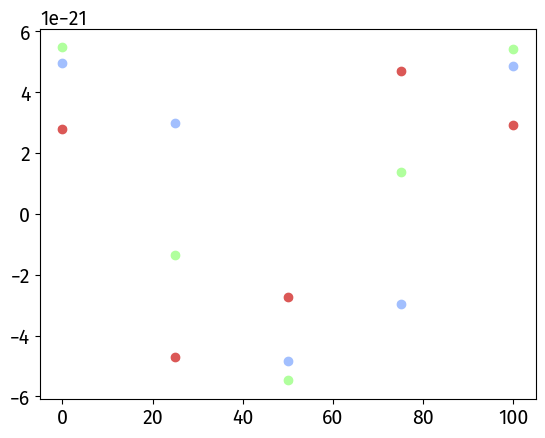

In [6]:
f_measured = []
f_err = []

t_starts = np.linspace(0,100,5)
for t0 in tqdm(t_starts):    
    signals,Ts = generate_signals(0.01,1200,1000,0,t0)
    phi_measured, phi_err = clock_average(signals,Ts)    
    f_measured.append(phi_measured/(np.mean(Ts)*f0*2*np.pi))
    f_err.append(phi_err/(np.mean(Ts)*f0*2*np.pi))

plt.errorbar(t_starts,f_measured,f_err,color = BLUE,marker='o', markersize=6,elinewidth=1.5,capsize = 3,
                linestyle='none',label = '$\phi = 0$')



f_measured = []
f_err = []
for t0 in tqdm(t_starts):    
    signals,Ts = generate_signals(0.01,1200,1000,np.pi/4,t0)
    phi_measured, phi_err = clock_average(signals,Ts)    
    f_measured.append(phi_measured/(np.mean(Ts)*f0*2*np.pi))
    f_err.append(phi_err/(np.mean(Ts)*f0*2*np.pi))

plt.errorbar(t_starts,f_measured,f_err,color = GREEN,marker='o', markersize=6,elinewidth=1.5,capsize = 3,
                linestyle='none',label = '$\phi = \pi/4$')




f_measured = []
f_err = []
for t0 in tqdm(t_starts):    
    signals,Ts = generate_signals(0.01,1200,1000,np.pi/2,t0)
    phi_measured, phi_err = clock_average(signals,Ts)    
    f_measured.append(phi_measured/(np.mean(Ts)*f0*2*np.pi))
    f_err.append(phi_err/(np.mean(Ts)*f0*2*np.pi))

plt.errorbar(t_starts,f_measured,f_err,color = RED,marker='o', markersize=6,elinewidth=1.5,capsize = 3,
                linestyle='none',label = '$\phi = \pi/2$')

# plt.savefig('plots/chirped_signals.pdf')
    

In [13]:
np.sum(np.array(Ts))/3600

np.float64(32.992600012006356)

np.float64(4.845558760258788e-23)

np.float64(4.813892221171657e-21)